<a href="https://colab.research.google.com/github/juangross/cursoAM2021/blob/main/PDI_TP6_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practico TP6 (Convolución)
Implementar un aplicativo que levante una imagen en nivel de gris (o que la convierta a YIQ y retenga solo el Y) y aplique el filtrado por convolución para los siguientes filtros:
1. Pasabajos: Plano y Bartlett 3x3, 5x5, 7x7. Gaussiano 5x5 y 7x7.
2. Detectores de bordes: Laplaciano v4 y v8. Sobel las 8 orientaciones.
3. Pasabanda, pasaaltos de frecuencia de corte 0,2 y 0,4
Respecto del “cierre” de la imagen cerca de los bordes, implementar la técnica no matemáticamente perfecta de “repetir” artificialmente filas o columnas cuando estas hagan falta. Por ejemplo, si el kernel es 3x3 y estoy en la primera columna, y no hay ninguna columna a la izquierda, entonces repito la primera columna como si estuviese en la imagen original. Otra opción es la conocida como padding en la cual adicionamos filas y columnas de ceros en los extremos de la imagen, similar al que les mostré para hacer que dos imágenes tengan el mismo tamaño.
Deben mostrar el aplicativo que permita cargar o seleccionar la imagen y elegir de una lista el filtro a aplicar ver su resultado. Adicionalmente deben mostrar un plot con todos los filtros aplicados para la imagen de entrada.
Nota: La función de convolución debe ser desarrollada por ustedes, NO mediante funciones de biblioteca.
Fecha de Entrega: 05 de Noviembre.
Saludos,

## **Bloque 1** - carga de imágenes

In [2]:
#importo material de trabajo
!git clone https://github.com/juangross/cursoPDI2021


Cloning into 'cursoPDI2021'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 201 (delta 64), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (201/201), 32.57 MiB | 11.36 MiB/s, done.
Resolving deltas: 100% (64/64), done.


**Bloque 2** - Definición de funciones básicas

In [30]:
#@title

import matplotlib.pyplot as plt
import imageio as img
import numpy as np
from scipy import fftpack
import fnmatch
import os


#cargo imágenes de prueba
# Import an image from directory:
path="./cursoPDI2021/imagenes/"
ext="png"

def Mostrar(Img1,Txt1,Img2,Txt2,Img3,Txt3):
  plt.figure (dpi=200)
  ax1=plt.subplot(1,3,1)
  plt.imshow(Img1)
  plt.title(Txt1)
  #plt.setp(ax1.get_yticklabels(), fontsize=6)
  #plt.setp(ax1.get_xticklabels(), fontsize=6)
  plt.axis('off')

  ax2=plt.subplot(1,3,2, sharey=ax1)
  plt.imshow(Img2)
  plt.title(Txt2)
  #plt.setp(ax2.get_yticklabels(), visible=False)
  #plt.setp(ax2.get_xticklabels(), fontsize=6)
  plt.axis('off')

  ax3= plt.subplot(1,3,3, sharey=ax1)
  plt.imshow(Img3)
  plt.title(Txt3)
  #plt.setp(ax3.get_yticklabels(), visible=False)
  #plt.setp(ax3.get_xticklabels(), fontsize=6)
  plt.axis('off')
  plt.show()

#normalizar imagenes
def normImg(Img1):
  return 1/255*Img1

#transformo a 
def RGB_TO_YIQ(RGBImage ):
  #matriz de conversión de RGB -> YIQ
  RGB2YIQ=np.array([[0.299,0.587,0.114],
                    [0.595716,-0.274453,-0.321263],
                    [0.211456,-0.522591,0.311135]], dtype=float)

  #me baso en esta explicación del producto matricial para hacer la conversión de bases
  #https://stackoverflow.com/questions/46990838/numpy-transforming-rgb-image-to-yiq-color-space
  YIQ_image=np.zeros(RGBImage.shape, dtype=float)
  YIQ_image=np.dot(RGBImage,RGB2YIQ.T.copy())
  return YIQ_image

def YIQ_TO_RGB(YIQImage ):
  #matriz de conversión de RGB -> YIQ
  RGB2YIQ=np.array([[1,0.9663,0.6210],
                    [1,-0.2721,-0.6474],
                    [1,-0.1070,1.7046]], dtype=float)

  #me baso en esta explicación del producto matricial para hacer la conversión de bases
  #https://stackoverflow.com/questions/46990838/numpy-transforming-rgb-image-to-yiq-color-space
  RGB_image=np.zeros(YIQImage.shape, dtype=float)
  RGB_image=np.dot(YIQImage,RGB2YIQ.T.copy())
  return RGB_image

def sumaYIQ(Img1, Img2):
  input_tam=Img1.shape
  #Resultado=np.zeros(input_tam, dtype=float)
  yiq3=np.zeros(input_tam, dtype=float)

  #normalizo la imagen de entrada
  nImg1=1/255*Img1.astype('float') #la imagen queda en tipo float
  nImg2=1/255*Img2.astype('float') #la imagen queda en tipo float
  yiq1=RGB_TO_YIQ (nImg1)
  yiq2=RGB_TO_YIQ (nImg2)

  #sumo las imágenes con cada canal por separado
  #se interpolan los canales IQ mediante:
  #IC= (YA * IA + YB * IB) / (YA + YB)
  #QC= (YA * QA + YB * QB) / (YA + YB)
  #yiq3[:,:,0]=yiq1[:,:,0]/2+yiq2[:,:,0]/2 #suma el canal Y promediando
  #yiq3[:,:,1]=yiq1[:,:,1]+yiq2[:,:,1] 
  #yiq3[:,:,2]=yiq1[:,:,2]+yiq2[:,:,2] 
  
  yiq3[:,:,0]=yiq1[:,:,0]+yiq2[:,:,0] #luego hay que recortar
  yiq3[:,:,1]=(yiq1[:,:,0]*yiq1[:,:,1]+yiq2[:,:,0]* yiq2[:,:,1])/(yiq1[:,:,0]+yiq2[:,:,0])
  yiq3[:,:,2]=(yiq1[:,:,0]*yiq1[:,:,2]+yiq2[:,:,0]* yiq2[:,:,2])/(yiq1[:,:,0]+yiq2[:,:,0])
  #print (yiq3)

  #recorto los valores extremos y converito nuevamente a RGB
  yiq3[:,:,0]=np.clip(yiq3[:,:,0],0,1) #recorto los valores Y
  yiq3[:,:,1]=np.clip(yiq3[:,:,1],-.5957,.5957) #recorto los valores I
  yiq3[:,:,2]=np.clip(yiq3[:,:,2],-.5226,.5226) #recorto los valores Q
  Img3= YIQ_TO_RGB(yiq3)
  #print (yiq3)

  #desnormalizar
  Img3=255*Img3
  Img3=np.rint(Img3)  #redondeo a valores enteros
  Img3=np.clip(Img3,0,255) #recorto los valores que superen 255
  return Img3

  #desnormalizar
  Img3=255*Img3
  Img3=np.rint(Img3)  #redondeo a valores enteros
  Img3=np.clip(Img3,0,255) #recorto los valores que superen 255
  return Img3


#ContarValores(): cuenta valores contenidos en una lista basado en otra lista con las escalas (bins)
#Lista: lista que contiene los valores a calcular el histograma.
#Bins: lista con los rangos de valores a usar como rangos de cada Bin
#   Al hacer "lista < valor" se produce otra lista cuyo contenido es booleano
#   pero y cuyos valores True cumplen con la condición
#   el resultado de la línea completa es una máscara booleana donde aparecen valores True 
#   en las posiciones cuyos valores se encuentran dentro del rango establecido por los bins

def ContarValores(Lista, lista_Bins):
  size=len(lista_bins)
  cont = np.zeros(size)
  #cont = np.zeros(N_bins+1)
  for i in range (0, (size -1)):
#   print(np.count_nonzero(Lista>=Bins[i]) & (Lista<Bins[i+1]).sum())
    cont[i]=np.count_nonzero(Lista>=lista_bins[i]) & (Lista<lista_bins[i+1]).sum()
  return cont


#Funciones usadas para el ajuste del canal Y por coeficiente alfa y por función

#ClipYIQ(): toma una imagen en YIQ y aplica los coeficientes de recorte a los valores para mantenerlos en el rango YIQ 
def ClipYIQ(ImgYIQ):
  ImgYIQ[:,:,0]=np.clip(ImgYIQ[:,:,0],0,1) #recorto los valores Y
  ImgYIQ[:,:,1]=np.clip(ImgYIQ[:,:,1],-.5957,.5957) #recorto los valores I
  ImgYIQ[:,:,1]=np.clip(ImgYIQ[:,:,1],-.5226,.5226) #recorto los valores Q
  return ImgYIQ


#escalaYIQparte1(): realiza la conversión de RGB a YIQ 
def escalaYIQpartel(RGBImage):
  YIQimage=np.zeros(RGBImage.shape, dtype=float)

  #normalizo la imagen de entrada
  nRGBImage=1/255*RGBImage.astype('float') #la imagen queda en tipo float
  YIQimage=RGB_TO_YIQ (nRGBImage)
  return YIQimage
  

#escalaYIQparte2(): realiza la conversión de la imagen YIQ a RGB, y devuelve una imagen RGB desnormalizada lista para mostrar
def escalaYIQparte2 (YIQimage):
  #Img3= YIQ_TO_RGB(yiq3)
  RGBResultImage= YIQ_TO_RGB(YIQimage)

  #desnormalizar
  RGBResultImage=255*RGBResultImage
  RGBResultImage=np.rint(RGBResultImage)  #redondeo a valores enteros
  RGBResultImage=np.clip(RGBResultImage,0,255) #recorto los valores que superen 255
  return RGBResultImage


def ListarArchivos(path):
  from os import listdir
  from os.path import join, isfile
  
#  #listado de archivos a procesar
#  for file in os.listdir(path):
#    if fnmatch.fnmatch(file, '*.png'):
#      print (file.split(".")[:-1])
#  #print(file)
        
  lista = [".".join(f.split(".")[:-1])  for f in os.listdir(path) if f.endswith('.png')]
  return lista

def CreaDatos(path,archi,ext):
  #Lee imagen con el formato actual
  Img1=(img.imread(f"{path}{archi}.{ext}"))      #lee con imageio
  Img1=Img1.astype('float')/255 #normalizo
  Img1=np.clip(Img1,0.,1.)  #recorto los valores extremos al rango [0:1] 
  #print("leyendo archivo:", f"{path}{archi}.{ext}", Img1.shape)
  
  Img1_yiq=RGB_TO_YIQ(Img1)
  dimension=Img1_yiq.shape
  #print(Img1_yiq.shape)

  #FFT de la imagen original
  fimg = np.zeros(Img1_yiq[:,:,0].shape)
  fimg = np.fft.fft2(Img1_yiq[:,:,0]) #fft del canal Y de la imagen en YIQ
  #fimg = np.fft.fftshift(fimg) #ajusto al centro
  #print(fimg.shape)
  #print(fimg)

  #magnitud y fase de la imagen original
  mag = np.zeros(fimg.shape)
  mag_log = np.zeros(dimension)
  phase = np.zeros(fimg.shape)
  mag = np.abs(fimg)  

  # Coef BMP <- round( 32 * log( coef TF ) )
  mag_log[:,:,0] = np.round(np.log(mag)*32)      #ajuste propuesto por Claudio
  #los datos de magnitud quedan escalados en el rango [0:255]
  #NOTA: grabo la magnitud en el canal 0, para que grabe en el canal R de la imagen en disco

  #mag_log= mag   #bypass para pruebas
  phase = np.angle(fimg)  
  #np.angle devuelve un array en el rango [-pi : pi]
  #lo escalo y desplazo para poder meterlo en el rango [0:255]
  phase_shift = np.add(phase,3.141592653589793)
  phase_scaled= phase_shift *40           #6.28 * 40 = 250
  phase_round= np.zeros(dimension)
  phase_round[:,:,0]= np.round(phase_scaled)     #datos de fase escalados para escribir en archivo
  #NOTA: grabo la fase en el canal 0, para que grabe en el canal R de la imagen en disco

  #genero los archivos de magnitud y fase separados para usar en la síntesis cruzada
  plt.imsave(f"{path}{archi}.m", mag_log.astype('uint8'), format='bmp')
  plt.imsave(f"{path}{archi}.a", phase_round.astype('uint8'), format='bmp')

  #print("datos creados:",f"{path}{archi}.m")
  #print("datos creados:",f"{path}{archi}.a")
  
  #en un inicio probe grabar los datos de magnitud y fase directamente en un archivo de texto
  #np.savetxt(f"{path}{archi}.m", mag, fmt='%.4e')
  #np.savetxt(f"{path}{archi}.a", phase, fmt='%.4e')


#Filtrar: aplica el kernel a la imagen, mediante una convolución
#retorna: matriz compleja representando la imagen filtrada
#observaciones: NO TRATA los bordes (por ahora)


def filtrar(fimg, kernel):
  fimg_mod=np.zeros(fimg.shape,dtype='complex')

  #calculo límites del kernel
  kx=kernel.shape[0]//2  +1 #ancho del kernel /2
  ky=kernel.shape[0]//2  +1 #alto del kernel /2
  print(kx,ky)
  for i in range(kx,fimg.shape[0]-kx,1):
      for j in range(ky, fimg.shape[1]-ky,1):
#        if (i>=kx) and  (j>=ky) and (i<fimg.shape[0]-kx-1) and  (j>=fimg.shape[1]-ky-1):
        if (i>=kx) and  (j>=ky):
            ven=fimg[i-kx:i+kx-1,j-ky:j+ky-1]
#            print("ventana: ", ven.shape)
#            kern=kernel
#            print("kernel: ", kernel.shape)
            fimg_mod[i-1,j-1]=np.sum(np.multiply(ven, kernel ))
#trabajo los bordes (en progreso)
#  for i in range(0,kx-1):
#      for j in range(fimg.shape[1]-ky):
#            ven=fimg[i:i+kx-1,j:j+kernel.shape[1]]
#            kern=kernel[kx:kernel.shape[0],:]
#            print("ventana: ",ven)
#            print(ven)
#            fimg_mod[i-1,j-1]=np.sum(np.multiply(ven, kern ))
  return fimg_mod


**Bloque 3** - Generación y regeneración de Fourier para UN archivo

In [25]:
#cargo imágenes de prueba
# Import an image from directory:
path="./cursoPDI2021/imagenes/"
ext="png"

#Procurar buscar imágenes que tengan el mismo tamaño
archi = "milo4r" #@param [ 'cuadrado_hueco_150p', 'cuadrado_1p', 'circulo_50p', 'rombo_2', 'rectangulo_25x100p', 'cuadrado_10x10p', 'circulo_20p', 'triangulos_2', 'milo4r', 'cuadrado_5x5p','triangulo','rectangulo_100x25p']
magnitud_modificada=  "1:1" #@param [ "1:1", "log Claudio"]


#Lee imagen con el formato actual
Img1=(img.imread(f"{path}{archi}.{ext}"))      #lee con imageio
Img1=Img1.astype('float')/255 #normalizo
Img1=np.clip(Img1,0.,1.)  #recorto los valores extremos al rango [0:1] 
print("leyendo archivo:", f"{path}{archi}.{ext}", Img1.shape)

Img1_yiq=RGB_TO_YIQ(Img1)
#print(Img1_yiq.shape)

#FFT de la imagen original
fimg = np.zeros(Img1_yiq[:,:,0].shape)
fimg = fftpack.fft2(Img1_yiq[:,:,0]) #scipy
#fimg = np.fft.fft2(Img1_yiq[:,:,0]) #fft del canal Y de la imagen en YIQ
fimg = np.fft.fftshift(fimg) #ajusto al centro
#print(fimg.shape)
#print(fimg)

#magnitud y fase de la imagen original
mag = np.zeros(fimg.shape)
mag_log = np.zeros(fimg.shape)
phase = np.zeros(fimg.shape)
mag = np.abs(fimg)  

# Coef BMP <- round( 32 * log( coef TF ) )
if magnitud_modificada=="log Claudio":
  mag_log = (np.log(mag)*32)       #ajuste propuesto por Claudio
  mag_log = np.clip(mag_log,0,255)   #recorto los valores que superen 255
elif magnitud_modificada=="1:1":
  mag_log = mag   #bypass para pruebas

phase = np.angle(fimg)



leyendo archivo: ./cursoPDI2021/imagenes/milo4r.png (480, 853, 3)


** Bloque 4** - definición de los kernels de los filtros


In [26]:
#@title
kbartlett3=np.array([[1,2,1],
                 [2,4,2],
                 [1,2,1]])
#print("kernel: ",kernel)
kbartlett5=np.array([[1,2,3,2,1],
                 [2,4,6,4,2],
                 [3,6,9,6,3],
                 [2,4,6,4,2],
                 [1,2,3,2,1]])

kbartlett7=np.array([[1,2,3,4,3,2,1],
                     [2,4,6,8,6,4,2],
                     [3,6,9,12,9,6,3],
                     [4,8,12,16,12,8,4],
                     [3,6,9,12,9,6,3],
                     [2,4,6,8,6,4,2],
                     [1,2,3,4,3,2,1]])

gauss5=np.array([[1,4,6,4,1],
                 [4,16,24,16,4],
                 [6,24,36,24,6],
                 [4,16,24,16,4],
                 [1,4,6,4,1]])



#matriz de prueba, ver planilla de cálculo
mprueba=np.array([[1,2,3,4,5,6],
     [1,2,3,4,5,6],
     [1,2,3,4,5,6],
     [1,2,3,4,5,6],
     [1,2,3,4,5,6],
     [1,2,3,4,5,6]])


**Bloque 5** - aplico filtro a la imagen seleccionada en bloque 3

In [28]:
import numpy as np
#kernel=gauss5
kernel=kbartlett3
#print("kernel: \n",kernel)

#trabajo con el canal Y de la imagen, aplico el filtro a la magnitud de la FFT

#mprueba: matriz de prueba para probar la convolución
#mag: magnitud de la FFT del canal Y de la imagen cargada en el bloque 3
fimg_mod=np.zeros(fimg.shape,dtype='complex')
print("imagen orignal: ", mag.shape)
print("kernel: ", kernel.shape)
fimg_mod=filtrar(mag, kernel)
#fimg_mod=filtrar(mag, kernel)
#fimg_mod=filtrar(mag, kernel)


print("imagen orignal: ", mag)
print("imagen filtrada: ", fimg_mod)

#reconstrucción de la imagen usando la magnitud modificada
#reconstruyo en etapas basado en magnitud y fase separadas



imagen orignal:  (480, 853)
kernel:  (3, 3)
imagen orignal:  [[1.76949391 2.74765171 4.89273379 ... 4.89273379 2.74765171 1.76949391]
 [1.39035073 2.22514053 3.18145203 ... 4.27494536 1.95609765 1.00523425]
 [1.58755015 1.60753166 3.1258699  ... 6.11349268 3.86829192 1.33858604]
 ...
 [1.0606945  2.90585016 4.07787891 ... 2.86659056 1.12798789 1.50223491]
 [1.33858604 3.86829192 6.11349268 ... 3.1258699  1.60753166 1.58755015]
 [1.00523425 1.95609765 4.27494536 ... 3.18145203 2.22514053 1.39035073]]
imagen filtrada:  [[ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j 38.1301821 +0.j 54.79945071+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j 31.50385179+0.j 44.97586097+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ..

**Bloque 6** - reconstruyo imagen

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part


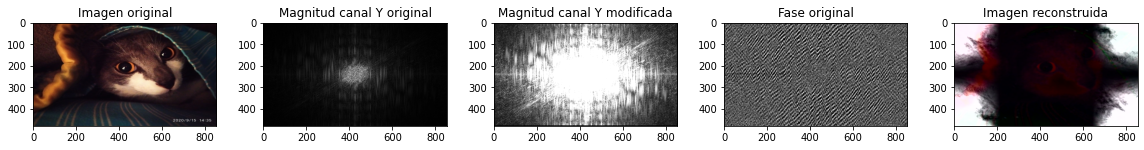

In [29]:

#genero los archivos de magnitud y fase separados para usar en la síntesis cruzada
#np.savetxt(f"{path}{archi}_m.txt", mag, fmt='%.4e')
#np.savetxt(f"{path}{archi}_a.txt", phase, fmt='%.4e')


#reconstrucción de la imagen usando la magnitud modificada
#reconstruyo en etapas basado en magnitud y fase separadas
#fimg_mod=np.zeros(fimg.shape,dtype='complex')
#fimg_mod= np.cos(phase)+np.sin(phase) *1j
#fimg_mod=mag_log*fimg_mod #escalo de acuerdo a la magnitud
#print(fimg_mod.shape)
#print(fimg_mod)

#inicializo el array que contiene la imagen reconstruida 
#y le precargo los canales YQ de la imagen original
#imagen reconstruida YIQ = imagen orginal con canal Y alterado, IQ originales
Img1_yiq_mod=np.zeros(Img1_yiq.shape, dtype='complex')

Img1_yiq_mod[:,:,0]= np.fft.ifft2(np.fft.fftshift(fimg_mod)) #cargo canal Y resultado de la FFT inversa
#Img1_yiq_mod[:,:,0]= np.fft.ifft2((fimg_mod)) #cargo canal Y resultado de la FFT inversa con el filtro aplicado
#Img1_yiq_mod[:,:,0]= fftpack.ifft2((fimg_mod)) #version scipy
Img1_yiq_mod[:,:,1]=Img1_yiq[:,:,1]     #copio canal I original
Img1_yiq_mod[:,:,2]=Img1_yiq[:,:,2]     #copio canal Q original

Img1_yiq_mod=ClipYIQ(Img1_yiq_mod)          #recorto la imagen YIQ al rango válido

Img1_mod= YIQ_TO_RGB(Img1_yiq_mod)          #convierte espacio YIQ a RGB
Img1_mod=255*Img1_mod                       #desnormalizo la imagen
Img1_mod=np.rint(Img1_mod)                  #redondeo a valores enteros
Img1_mod=np.clip(Img1_mod,0,255)            #recorto los valores que superen 255
#print(Img1_mod)

#figura base
fig, axs = plt.subplots(1, 5, tight_layout=True,figsize=(16, 16))

axs[0].imshow( Img1)
axs[0].set_title("Imagen original")

#magnitud del espectro centrado
axs[1].imshow(np.abs(fimg).astype('uint8'),cmap= 'gray')
axs[1].set_title("Magnitud canal Y original")

#axs[2].imshow(np.abs((fimg_mod)).astype('uint8'),cmap= 'gray')
axs[2].imshow(np.clip(np.abs((fimg_mod)),0,255).astype('uint8'),cmap= 'gray')
axs[2].set_title("Magnitud canal Y modificada")

axs[3].imshow(phase.astype('uint8'),cmap= 'gray')
axs[3].set_title("Fase original")

axs[4].imshow( Img1_mod.astype('uint8'))
axs[4].set_title("Imagen reconstruida")
plt.show()
